<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다<font color =green> 이전에는 seasonality가 확실한 데이터에 대해서만 진행을 했다면 이제는 비교적 변동성이 큰 데이터에 대해서 진행을 해보겠다</font></font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = pd.read_csv('../data/sales.csv',names=['datetime','sales'])
data

,datetime,sales
0,2020-05-01 00:00:00,27
1,2020-05-02 00:00:00,37
2,2020-05-03 00:00:00,33
3,2020-05-04 00:00:00,26
4,2020-05-05 00:00:00,30
...,...,...
725,2022-04-26 00:00:00,25
726,2022-04-27 00:00:00,25
727,2022-04-28 00:00:00,29
728,2022-04-29 00:00:00,21


In [6]:
data.drop(columns=['datetime'],inplace=True)
data

,sales
0,27
1,37
2,33
3,26
4,30
...,...
725,25
726,25
727,29
728,21


In [7]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_DLinear_sales']= {
    'seq_len':14,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online_learning_DLinear_sales','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_DLinear_sales')

['/hdd_1/sjlee/Model_Implementation/online_learning_DLinear_sales']

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online_learning_DLinear_sales']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online_learning_DLinear_sales']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online_learning_DLinear_sales']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online_learning_DLinear_sales']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() # 새로로 펼친걸 가로로 늘림
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 14
pred_len = 1
split= 14
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_362277/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq.size()

torch.Size([702, 1, 14])

In [21]:
batch_size = 1
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()

In [22]:
for a,b in training:
    print(a,b)
    print(a.size(),b.size())
    break

tensor([[[27., 37., 33., 26., 30., 21., 29., 30., 31., 27., 38., 14., 27., 33.]]],
       device='cuda:0') tensor([[[28.]]], device='cuda:0')
torch.Size([1, 1, 14]) torch.Size([1, 1, 1])


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [23]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 39.212289091889176 %
smape 33.216280514567615 %
smape 31.618916841502102 %
smape 31.065364612425288 %
smape 30.531994686869936 %
smape 30.531922578167585 %
smape 30.27554474312658 %
smape 30.18864467047081 %
smape 30.182321300375058 %
smape 30.19128561667396 %
smape 30.23635394077368 %
smape 30.23604342932521 %
smape 30.210271487549807 %
smape 30.18981526795188 %
smape 30.2184901608186 %
smape 30.122089400679204 %
smape 30.201370494438624 %
smape 30.136007308429956 %
smape 30.084385267346754 %
smape 30.041128491127612 %
smape 30.06706707899431 %
smape 30.099659260905327 %
smape 30.033881810105385 %
smape 30.020714351143337 %
smape 30.109779563912543 %
smape 30.019337147732948 %
smape 30.126416559543056 %
smape 30.023831643606602 %
smape 30.12847867276208 %
smape 30.117247202911244 %
smape 30.021653196319125 %
smape 30.024692531495333 %
smape 30.03676527435493 %
smape 30.05677307331556 %
smape 30.025234159008047 %
smape 29.948323944190015 %
smape 30.053833572716687 %
smape 29.9277

In [24]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    for epochs in range(num_epochs):
        if idx == 0:
             new_train = torch.FloatTensor(
            [X.iloc[-sequence_length:].values]
        ).view(1,1,sequence_length).to(device)
                
        else:
            new_train = torch.FloatTensor(
                [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,1,sequence_length).to(device)

        out = model(new_train) # 예측완료
        
        tg = FloatTensor(target.iloc[idx]).view(1,1,1).to(device)
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(out.cpu().view(1).item())
    time_list.append(end-start)

SMAPE 8.761837849062431 %
SMAPE 50.72871998883783 %
SMAPE 12.558901347991194 %
SMAPE 1.3791194504826763 %
SMAPE 0.5241942640495836 %
SMAPE 1.4389268012455432 %
SMAPE 0.12034197138018499 %
SMAPE 2.038155838599778 %
SMAPE 9.327761377746356 %
SMAPE 8.427659136301372 %
SMAPE 0.1191919325865456 %
SMAPE 0.8000283332412437 %
SMAPE 6.81569709420728 %
SMAPE 1.2437301730460604 %


In [25]:
len(pred_list)

14

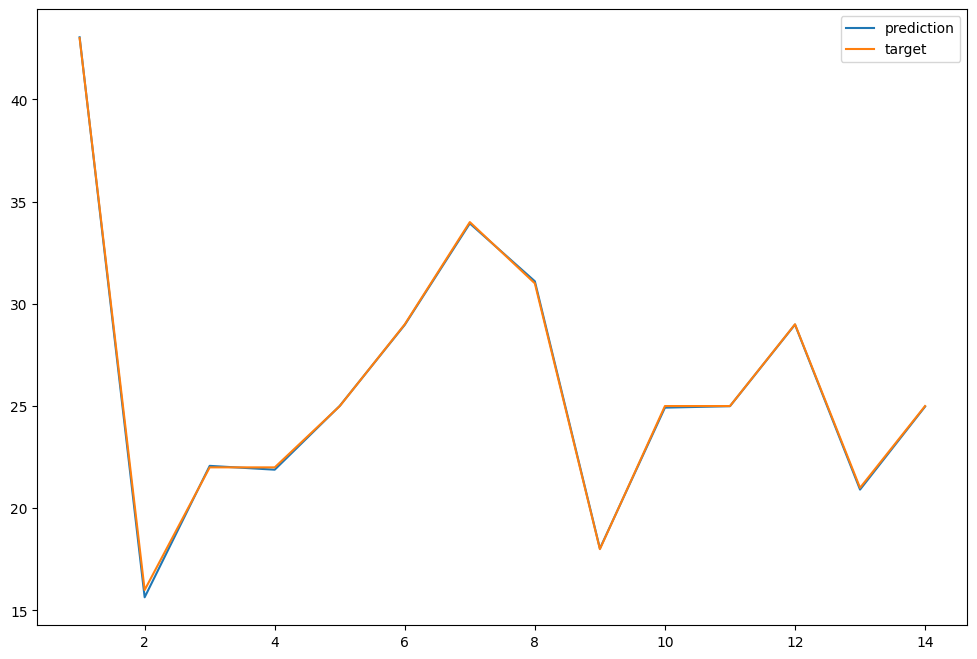

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,15),pred_list,label='prediction')
axes.plot(np.arange(1,15),target,label='target')
axes.legend()

In [28]:
np.array(pred_list)

array([43.03989029, 15.64478588, 22.07377243, 21.88629532, 25.00660133,
       28.97511864, 33.93334579, 31.1029892 , 18.0280571 , 24.92196846,
       24.99224472, 28.98496056, 20.91324043, 24.97402763])

In [29]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[43],
       [16],
       [22],
       [22],
       [25],
       [29],
       [34],
       [31],
       [18],
       [25],
       [25],
       [29],
       [21],
       [25]])

In [30]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([14]) torch.Size([14, 1])


In [31]:
SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100

tensor(0.3500)

In [33]:
len(time_list)

14

In [35]:
np.mean(time_list) # 한번 훈련하는데 걸린 시간 

0.1648899827684675

<font color = blue><font size = 6> Conclusion </font></font><br>
0.3퍼센트의 결과는 계절성이 clear한 데이터에서 나온 수치와 비슷한 수치이다 이는 계절성이 online-learning에서 주요한 요인이 아니라는 점을 시사한다